In [ ]:

#  Import libraries & config

import os
import zipfile
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
#zip_files = [r"C:\Users\ajsty\OneDrive\Desktop\new\Data-20250726T124359Z-1-001.zip\Data\CRWV.zip", r"C:\Users\ajsty\OneDrive\Desktop\new\Data-20250726T124359Z-1-001.zip\Data\FROG.zip", r"C:\Users\ajsty\OneDrive\Desktop\new\Data-20250726T124359Z-1-001.zip\Data\SOUN.zip"]
symbol = ["CRWV", "FROG", "SOUN"]




In [ ]:
#Load Raw MBP-10 Events CRWV
import os
import zipfile
import pandas as pd

symbol = "CRWV"
zip_path = r"C:\Users\ajsty\OneDrive\Desktop\new\Data-20250726T124359Z-1-001\Data\CRWV.zip"

def load_mbp10_events(zip_file, symbol):
    dfs = []
    with zipfile.ZipFile(zip_file, "r") as zf:
        for fname in zf.namelist():
            if fname.endswith(".csv") and symbol in fname:
                with zf.open(fname) as f:
                    try:
                        df = pd.read_csv(
                            f, encoding="latin1", engine="python", on_bad_lines="skip"
                        )
                        if df.empty or len(df.columns) == 0:
                            continue
                        if "symbol" in df.columns:
                            dfs.append(df[df["symbol"] == symbol])
                        else:
                            dfs.append(df)
                    except pd.errors.EmptyDataError:
                        continue

    if not dfs:
        raise FileNotFoundError("No matching CSVs found for symbol in ZIP.")
    data = pd.concat(dfs).sort_values("ts_event").reset_index(drop=True)
    return data

df_crwv = load_mbp10_events(zip_path, symbol)
print("✅ Loaded CRWV events")
print(df_crwv.head())


✅ Loaded CRWV events
                              ts_event                           ts_event.1  \
0  2025-04-03 13:30:00.012155347+00:00  2025-04-03 13:30:00.012155347+00:00   
1  2025-04-03 13:30:00.012155347+00:00  2025-04-03 13:30:00.012155347+00:00   
2  2025-04-03 13:30:00.012155347+00:00  2025-04-03 13:30:00.012155347+00:00   
3  2025-04-03 13:30:00.012344442+00:00  2025-04-03 13:30:00.012344442+00:00   
4  2025-04-03 13:30:00.012800457+00:00  2025-04-03 13:30:00.012800457+00:00   

   rtype  publisher_id  instrument_id action side  depth  price  size  ...  \
0     10             2          20613      T    B      0  55.40    99  ...   
1     10             2          20613      T    B      0  55.40   100  ...   
2     10             2          20613      T    N      0  55.40   551  ...   
3     10             2          20613      A    A      0  55.40   100  ...   
4     10             2          20613      A    B      0  55.39   100  ...   

   ask_sz_08  bid_ct_08  ask_ct_08 

In [ ]:
#  Reconstruct the limit order book 

import numpy as np

df_raw = df_crwv.copy()  # make sure we use the loaded CRWV data

levels = range(10)
bid_px = np.full(10, np.nan)
bid_sz = np.zeros(10)
ask_px = np.full(10, np.nan)
ask_sz = np.zeros(10)

snapshots = []
current_minute = None
row_counter = 0
snapshot_every = 5000

for _, row in df_raw.iterrows():
    try:
        ts = pd.to_datetime(row["ts_event"], utc=True)
    except Exception as e:
        print(f"Skipping row due to timestamp error: {e}")
        continue

    minute = ts.floor("min")  # 'T' is deprecated, use 'min'

    depth = int(row["depth"]) if not pd.isna(row["depth"]) else None
    side = str(row["side"]).strip()
    action = str(row["action"]).lower().strip()
    price = row["price"] if not pd.isna(row["price"]) else None
    size = row["size"] if not pd.isna(row["size"]) else 0

    if row_counter < 5:
        print(f"ts: {ts}, depth: {depth}, side: {side}, action: {action}, price: {price}, size: {size}")

    if depth is not None and 0 <= depth < 10 and price is not None:
        if side == "B":
            if action in ["add", "modify", "a", "m"]:
                bid_px[depth] = price
                bid_sz[depth] = size
            elif action in ["cancel", "c"]:
                bid_sz[depth] = max(0, bid_sz[depth] - size)
        elif side == "A":
            if action in ["add", "modify", "a", "m"]:
                ask_px[depth] = price
                ask_sz[depth] = size
            elif action in ["cancel", "c"]:
                ask_sz[depth] = max(0, ask_sz[depth] - size)

    row_counter += 1

    if (current_minute != minute) or (row_counter % snapshot_every == 0):
        snap = {
            "timestamp": minute,
            **{f"bid_px_{i:02d}": bid_px[i] for i in levels},
            **{f"bid_sz_{i:02d}": bid_sz[i] for i in levels},
            **{f"ask_px_{i:02d}": ask_px[i] for i in levels},
            **{f"ask_sz_{i:02d}": ask_sz[i] for i in levels},
        }
        snapshots.append(snap)
        current_minute = minute

print(f"✅ Total snapshots: {len(snapshots)}")

book_df_crwv = pd.DataFrame(snapshots).set_index("timestamp").ffill()
print(f"✅ Final book shape: {book_df_crwv.shape}")
print(book_df_crwv.head())


ts: 2025-04-03 13:30:00.012155347+00:00, depth: 0, side: B, action: t, price: 55.4, size: 99
ts: 2025-04-03 13:30:00.012155347+00:00, depth: 0, side: B, action: t, price: 55.4, size: 100
ts: 2025-04-03 13:30:00.012155347+00:00, depth: 0, side: N, action: t, price: 55.4, size: 551
ts: 2025-04-03 13:30:00.012344442+00:00, depth: 0, side: A, action: a, price: 55.4, size: 100
ts: 2025-04-03 13:30:00.012800457+00:00, depth: 0, side: B, action: a, price: 55.39, size: 100
✅ Total snapshots: 8562
✅ Final book shape: (8562, 40)
                           bid_px_00  bid_px_01  bid_px_02  bid_px_03  \
timestamp                                                               
2025-04-03 13:30:00+00:00        NaN        NaN        NaN        NaN   
2025-04-03 13:31:00+00:00      54.50      54.50      54.65      54.69   
2025-04-03 13:32:00+00:00      53.24      53.51      53.49      53.48   
2025-04-03 13:32:00+00:00      53.58      53.55      53.50      53.50   
2025-04-03 13:33:00+00:00      53.52 

In [ ]:
#Simulate Market Impact for Various Order Sizes
import numpy as np
import pandas as pd

# Sizes of hypothetical market orders (in shares)
market_sizes = [100, 500, 1000, 2000, 5000]

# Storage for results
impact_records = []

# Loop through each snapshot in the book
for ts, row in book_df_crwv.iterrows():
    ask_px = [row[f"ask_px_{i:02d}"] for i in range(10)]
    ask_sz = [row[f"ask_sz_{i:02d}"] for i in range(10)]

    # Skip invalid snapshots
    if np.isnan(ask_px[0]) or sum(ask_sz) == 0:
        impact_records.append([np.nan] * len(market_sizes))
        continue

    row_impact = []

    for size in market_sizes:
        remaining = size
        total_cost = 0.0

        for px, sz in zip(ask_px, ask_sz):
            if np.isnan(px) or sz == 0:
                continue
            take = min(remaining, sz)
            total_cost += take * px
            remaining -= take
            if remaining <= 0:
                break

        if remaining > 0:
            row_impact.append(np.nan)  # Not enough depth to fill order
        else:
            avg_fill_price = total_cost / size
            impact = avg_fill_price - ask_px[0]  # Impact vs best ask
            row_impact.append(impact)

    impact_records.append(row_impact)

# Create impact DataFrame
impact_df = pd.DataFrame(impact_records, columns=market_sizes, index=book_df_crwv.index)

# Show preview
print(impact_df.head())

# Optional: Save result
impact_df.to_csv("crwv_impact.csv")
print("✅ Step 3 Complete: Simulated market impact saved to crwv_impact.csv")


                             100   500   1000  2000  5000
timestamp                                                
2025-04-03 13:30:00+00:00     NaN   NaN   NaN   NaN   NaN
2025-04-03 13:31:00+00:00  0.2100   NaN   NaN   NaN   NaN
2025-04-03 13:32:00+00:00  0.0000   NaN   NaN   NaN   NaN
2025-04-03 13:32:00+00:00  0.0562   NaN   NaN   NaN   NaN
2025-04-03 13:33:00+00:00  0.0000   NaN   NaN   NaN   NaN
✅ Step 3 Complete: Simulated market impact saved to crwv_impact.csv


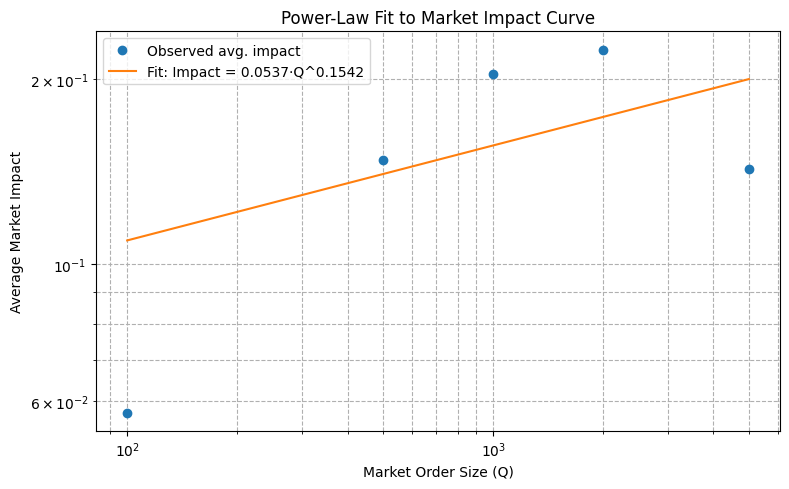

✅ Fitted parameters:
   α (alpha) = 0.0537
   β (beta) = 0.1542


In [ ]:
#Fit the Square-root Law of Market Impact (Power-law fit)
mport numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Load Step 3 output if not already in memory
impact_df = pd.read_csv("crwv_impact.csv", index_col=0)

# 1. Calculate average market impact per order size
avg_impact = impact_df.mean(skipna=True)
order_sizes = avg_impact.index.astype(int).values
impacts = avg_impact.values

# 2. Remove NaNs (in case some sizes couldn't be filled)
mask = ~np.isnan(impacts)
Q = order_sizes[mask]
I = impacts[mask]

# 3. Power-law model function
def power_law(q, alpha, beta):
    return alpha * q**beta

# 4. Fit the model
params, _ = curve_fit(power_law, Q, I, p0=[1e-3, 0.5], maxfev=10000)
alpha, beta = params

# 5. Predict for plot
Q_fit = np.linspace(Q.min(), Q.max(), 100)
I_fit = power_law(Q_fit, alpha, beta)

# 6. Plot the fit
plt.figure(figsize=(8, 5))
plt.plot(Q, I, 'o', label="Observed avg. impact")
plt.plot(Q_fit, I_fit, '-', label=f"Fit: Impact = {alpha:.4f}·Q^{beta:.4f}")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Market Order Size (Q)")
plt.ylabel("Average Market Impact")
plt.title("Power-Law Fit to Market Impact Curve")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.savefig("crwv_impact_fit.png")
plt.show()

# 7. Output parameters
print(f"✅ Fitted parameters:\n   α (alpha) = {alpha:.4f}\n   β (beta) = {beta:.4f}")


In [ ]:
#  Load Raw MBP-10 Events FROG
import os
import zipfile
import pandas as pd

symbol = "FROG"
zip_path = r"C:\Users\ajsty\OneDrive\Desktop\new\Data-20250726T124359Z-1-001\Data\FROG.zip"

def load_mbp10_events(zip_file, symbol):
    dfs = []
    with zipfile.ZipFile(zip_file, "r") as zf:
        for fname in zf.namelist():
            if fname.endswith(".csv") and symbol in fname:
                with zf.open(fname) as f:
                    try:
                        df = pd.read_csv(
                            f, encoding="latin1", engine="python", on_bad_lines="skip"
                        )
                        if df.empty or len(df.columns) == 0:
                            continue
                        if "symbol" in df.columns:
                            dfs.append(df[df["symbol"] == symbol])
                        else:
                            dfs.append(df)
                    except pd.errors.EmptyDataError:
                        continue

    if not dfs:
        raise FileNotFoundError("No matching CSVs found for symbol in ZIP.")
    data = pd.concat(dfs).sort_values("ts_event").reset_index(drop=True)
    return data

df_frog = load_mbp10_events(zip_path, symbol)
print("✅ Loaded FROG events")
print(df_frog.head())


✅ Loaded FROG events
                              ts_event                           ts_event.1  \
0  2025-04-03 13:30:00.125395235+00:00  2025-04-03 13:30:00.125395235+00:00   
1  2025-04-03 13:30:00.125739764+00:00  2025-04-03 13:30:00.125739764+00:00   
2  2025-04-03 13:30:00.125745044+00:00  2025-04-03 13:30:00.125745044+00:00   
3  2025-04-03 13:30:00.170027597+00:00  2025-04-03 13:30:00.170027597+00:00   
4  2025-04-03 13:30:00.404726961+00:00  2025-04-03 13:30:00.404726961+00:00   

   rtype  publisher_id  instrument_id action side  depth  price  size  ...  \
0     10             2           6292      C    B      4  29.70   100  ...   
1     10             2           6292      A    A      3  32.79   100  ...   
2     10             2           6292      A    B      4  29.74   100  ...   
3     10             2           6292      A    B      3  29.89   100  ...   
4     10             2           6292      A    B      7  29.13   100  ...   

   ask_sz_08  bid_ct_08  ask_ct_08 

In [ ]:
#Reconstruct the Limit Order Book
import numpy as np
import pandas as pd

def reconstruct_book(df, levels=10):
    # Initialize book storage
    book_snapshots = []
    timestamps = []

    # Book state: price and size arrays
    bid_px = np.full(levels, np.nan)
    bid_sz = np.zeros(levels)
    ask_px = np.full(levels, np.nan)
    ask_sz = np.zeros(levels)

    # Group by each second for snapshotting
    df['ts_event'] = pd.to_datetime(df['ts_event'])
    for i, row in df.iterrows():
        ts = row["ts_event"]
        depth = int(row["depth"])
        side = row["side"].upper()
        action = row["action"].lower()
        price = float(row["price"])
        size = float(row["size"])

        if depth >= levels or depth < 0:
            continue

        if side == "B":
            px_array = bid_px
            sz_array = bid_sz
        elif side == "A":
            px_array = ask_px
            sz_array = ask_sz
        else:
            continue

        if action == "a":  # Add
            px_array[depth] = price
            sz_array[depth] = size
        elif action == "c":  # Cancel
            if px_array[depth] == price:
                sz_array[depth] = max(0, sz_array[depth] - size)
        elif action == "d":  # Delete
            if px_array[depth] == price:
                px_array[depth] = np.nan
                sz_array[depth] = 0
        elif action == "t":  # Trade
            if px_array[depth] == price:
                sz_array[depth] = max(0, sz_array[depth] - size)
        else:
            continue

        # Create snapshot every second
        minute = ts.floor("1min")
        if len(book_snapshots) == 0 or timestamps[-1] != minute:
            snapshot = {}
            for i in range(levels):
                snapshot[f"bid_px_{i:02d}"] = bid_px[i]
                snapshot[f"bid_sz_{i:02d}"] = bid_sz[i]
                snapshot[f"ask_px_{i:02d}"] = ask_px[i]
                snapshot[f"ask_sz_{i:02d}"] = ask_sz[i]
            book_snapshots.append(snapshot)
            timestamps.append(minute)

    book_df = pd.DataFrame(book_snapshots, index=pd.to_datetime(timestamps))
    return book_df

book_df_frog = reconstruct_book(df_frog)
print(f"✅ Total snapshots: {len(book_df_frog)}")
print(f"✅ Final book shape: {book_df_frog.shape}")
print(book_df_frog.head())

# Optional: Save
book_df_frog.to_csv("frog_book.csv")
print("✅ Step 2 Complete: Reconstructed book saved to frog_book.csv")


✅ Total snapshots: 8156
✅ Final book shape: (8156, 40)
                           bid_px_00  bid_sz_00  ask_px_00  ask_sz_00  \
2025-04-03 13:30:00+00:00        NaN        0.0        NaN        0.0   
2025-04-03 13:31:00+00:00      31.07      100.0      31.50        0.0   
2025-04-03 13:32:00+00:00      31.41      100.0      31.87      100.0   
2025-04-03 13:33:00+00:00      31.41        0.0      31.87      100.0   
2025-04-03 13:34:00+00:00      31.41        0.0      31.87        3.0   

                           bid_px_01  bid_sz_01  ask_px_01  ask_sz_01  \
2025-04-03 13:30:00+00:00        NaN        0.0        NaN        0.0   
2025-04-03 13:31:00+00:00      31.04      100.0      31.54        5.0   
2025-04-03 13:32:00+00:00      31.15      200.0      31.91        0.0   
2025-04-03 13:33:00+00:00      31.15      200.0      31.91        0.0   
2025-04-03 13:34:00+00:00      31.24      200.0      31.91        0.0   

                           bid_px_02  bid_sz_02  ...  ask_px_07  as

In [ ]:
#Simulate Market Impact for Various Order Sizes
import numpy as np
import pandas as pd

# Load the reconstructed book from step 2
book_df_frog = pd.read_csv("frog_book.csv", index_col=0, parse_dates=True)

# Sizes of hypothetical market orders (in shares)
market_sizes = [100, 500, 1000, 2000, 5000]

# Storage for results
impact_records = []

# Loop through each snapshot in the book
for ts, row in book_df_frog.iterrows():
    ask_px = [row[f"ask_px_{i:02d}"] for i in range(10)]
    ask_sz = [row[f"ask_sz_{i:02d}"] for i in range(10)]

    # Skip invalid snapshots
    if np.isnan(ask_px[0]) or sum(ask_sz) == 0:
        impact_records.append([np.nan] * len(market_sizes))
        continue

    row_impact = []

    for size in market_sizes:
        remaining = size
        total_cost = 0.0

        for px, sz in zip(ask_px, ask_sz):
            if np.isnan(px) or sz == 0:
                continue
            take = min(remaining, sz)
            total_cost += take * px
            remaining -= take
            if remaining <= 0:
                break

        if remaining > 0:
            row_impact.append(np.nan)  # Not enough depth to fill order
        else:
            avg_fill_price = total_cost / size
            impact = avg_fill_price - ask_px[0]  # Impact vs best ask
            row_impact.append(impact)

    impact_records.append(row_impact)

# Create impact DataFrame
impact_df_frog = pd.DataFrame(impact_records, columns=market_sizes, index=book_df_frog.index)

# Show preview
print(impact_df_frog.head())

# Save result
impact_df_frog.to_csv("frog_impact.csv")
print("✅ Step 3 Complete: Simulated market impact saved to frog_impact.csv")


                             100     500     1000      2000  5000
2025-04-03 13:30:00+00:00     NaN     NaN     NaN       NaN   NaN
2025-04-03 13:31:00+00:00  0.3535  0.4616  0.4708  0.692625   NaN
2025-04-03 13:32:00+00:00  0.0000  0.2460     NaN       NaN   NaN
2025-04-03 13:33:00+00:00  0.0000  0.2340     NaN       NaN   NaN
2025-04-03 13:34:00+00:00  0.3298  0.3504     NaN       NaN   NaN
✅ Step 3 Complete: Simulated market impact saved to frog_impact.csv


✅ Fitted β: 0.0059, α: 0.4784


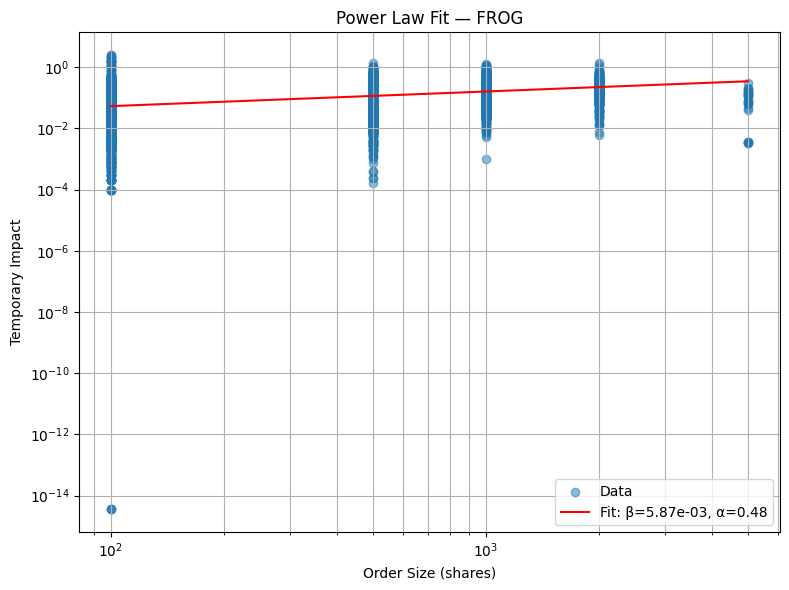

In [ ]:
#Fit the Square-root Law of Market Impact (Power-law fit
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Load the impact CSV
impact_df = pd.read_csv("frog_impact.csv", index_col=0, parse_dates=True)

# Define power-law function
def power_law(x, beta, alpha):
    return beta * np.power(x, alpha)

# Prepare the data for fitting
sizes = impact_df.columns.astype(int)  # [100, 500, 1000, ...]
x_data = np.concatenate([[s] * len(impact_df) for s in sizes])
y_data = np.concatenate([impact_df[str(s)].values for s in sizes])

# Remove NaNs
mask = ~np.isnan(y_data)
x_data = x_data[mask]
y_data = y_data[mask]

# Fit using curve_fit
(beta_est, alpha_est), _ = curve_fit(power_law, x_data, y_data, p0=[1e-4, 0.5])
print(f"✅ Fitted β: {beta_est:.4f}, α: {alpha_est:.4f}")

# Plot (log-log scale)
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, alpha=0.5, label="Data")
x_fit = np.linspace(100, 5000, 100)
y_fit = power_law(x_fit, beta_est, alpha_est)
plt.plot(x_fit, y_fit, color="red", label=f"Fit: β={beta_est:.2e}, α={alpha_est:.2f}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Order Size (shares)")
plt.ylabel("Temporary Impact")
plt.title("Power Law Fit — FROG")
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


In [ ]:
# Load Raw MBP-10 Events SOUN
import os
import zipfile
import pandas as pd

symbol = "SOUN"
zip_path = r"C:\Users\ajsty\OneDrive\Desktop\new\Data-20250726T124359Z-1-001\Data\SOUN.zip"

def load_mbp10_events(zip_file, symbol):
    dfs = []
    with zipfile.ZipFile(zip_file, "r") as zf:
        for fname in zf.namelist():
            if fname.endswith(".csv") and symbol in fname:
                with zf.open(fname) as f:
                    try:
                        df = pd.read_csv(
                            f, encoding="latin1", engine="python", on_bad_lines="skip"
                        )
                        if df.empty or len(df.columns) == 0:
                            continue
                        if "symbol" in df.columns:
                            dfs.append(df[df["symbol"] == symbol])
                        else:
                            dfs.append(df)
                    except pd.errors.EmptyDataError:
                        continue

    if not dfs:
        raise FileNotFoundError("No matching CSVs found for symbol in ZIP.")
    data = pd.concat(dfs).sort_values("ts_event").reset_index(drop=True)
    return data

df_soun = load_mbp10_events(zip_path, symbol)
print("✅ Loaded SOUN events")
print(df_soun.head())


✅ Loaded SOUN events
                              ts_event                           ts_event.1  \
0  2025-04-03 13:30:00.005642878+00:00  2025-04-03 13:30:00.005642878+00:00   
1  2025-04-03 13:30:00.005948702+00:00  2025-04-03 13:30:00.005948702+00:00   
2  2025-04-03 13:30:00.013021640+00:00  2025-04-03 13:30:00.013021640+00:00   
3  2025-04-03 13:30:00.015953598+00:00  2025-04-03 13:30:00.015953598+00:00   
4  2025-04-03 13:30:00.016252285+00:00  2025-04-03 13:30:00.016252285+00:00   

   rtype  publisher_id  instrument_id action side  depth  price  size  ...  \
0     10             2          14993      A    B      1   7.88   100  ...   
1     10             2          14993      A    A      1   7.92   100  ...   
2     10             2          14993      C    A      0   7.91    84  ...   
3     10             2          14993      A    A      1   7.92   100  ...   
4     10             2          14993      T    A      0   7.89    92  ...   

   ask_sz_08  bid_ct_08  ask_ct_08 

In [ ]:
#Reconstruct the Limit Order Book
import numpy as np
import pandas as pd
from datetime import datetime

# Step 1: Load only essential columns
symbol = "SOUN"
zip_path = r"C:\Users\ajsty\OneDrive\Desktop\new\Data-20250726T124359Z-1-001\Data\SOUN.zip"

import zipfile

def load_mbp10_events_optimized(zip_file, symbol):
    dfs = []
    with zipfile.ZipFile(zip_file, "r") as zf:
        for fname in zf.namelist():
            if fname.endswith(".csv") and symbol in fname:
                with zf.open(fname) as f:
                    try:
                        df = pd.read_csv(f,
                                         encoding="latin1",
                                         engine="python",
                                         on_bad_lines="skip",
                                         usecols=["ts_event", "depth", "side", "action", "price", "size", "symbol"])
                        if "symbol" in df.columns:
                            dfs.append(df[df["symbol"] == symbol])
                        else:
                            dfs.append(df)
                    except Exception:
                        continue

    if not dfs:
        raise FileNotFoundError(f"No CSVs found for {symbol}")
    data = pd.concat(dfs).sort_values("ts_event").reset_index(drop=True)
    return data

# Load data
df_soun = load_mbp10_events_optimized(zip_path, symbol)
print(f"✅ Loaded {symbol} data: {len(df_soun)} rows")

# Step 2: Reconstruct Book

levels = range(10)
bid_px = np.full(10, np.nan)
bid_sz = np.zeros(10)
ask_px = np.full(10, np.nan)
ask_sz = np.zeros(10)

snapshots = []
current_minute = None
row_counter = 0
snapshot_every = 5000  # You can increase this for faster performance

# Use .itertuples() for faster iteration
for row in df_soun.itertuples(index=False):
    try:
        ts = pd.to_datetime(row.ts_event, utc=True)
    except Exception as e:
        print(f"⛔ Timestamp error: {e}")
        continue

    minute = ts.floor("min")

    depth = int(row.depth) if not pd.isna(row.depth) else None
    side = str(row.side).strip().upper()
    action = str(row.action).lower().strip()
    price = row.price if not pd.isna(row.price) else None
    size = row.size if not pd.isna(row.size) else 0

    if row_counter < 5:
        print(f"ts: {ts}, depth: {depth}, side: {side}, action: {action}, price: {price}, size: {size}")

    if depth is not None and 0 <= depth < 10 and price is not None:
        if side == "B":
            if action in ["add", "modify", "a", "m"]:
                bid_px[depth] = price
                bid_sz[depth] = size
            elif action in ["cancel", "c"]:
                bid_sz[depth] = max(0, bid_sz[depth] - size)
        elif side == "A":
            if action in ["add", "modify", "a", "m"]:
                ask_px[depth] = price
                ask_sz[depth] = size
            elif action in ["cancel", "c"]:
                ask_sz[depth] = max(0, ask_sz[depth] - size)

    row_counter += 1

    # Progress update
    if row_counter % 100000 == 0:
        print(f"✅ Processed {row_counter} rows...")

    if current_minute != minute or (row_counter % snapshot_every == 0):
        snap = {
            "timestamp": minute,
            **{f"bid_px_{i:02d}": bid_px[i] for i in levels},
            **{f"bid_sz_{i:02d}": bid_sz[i] for i in levels},
            **{f"ask_px_{i:02d}": ask_px[i] for i in levels},
            **{f"ask_sz_{i:02d}": ask_sz[i] for i in levels},
        }
        snapshots.append(snap)
        current_minute = minute

# Convert snapshots to DataFrame
book_df_soun = pd.DataFrame(snapshots).set_index("timestamp").ffill()

print(f"\n✅ Total snapshots: {len(snapshots)}")
print(f"✅ Final book shape: {book_df_soun.shape}")
print(book_df_soun.head())

# Optional: Save result
book_df_soun.to_csv("soun_book.csv")
print("✅ Step 2 Complete: Reconstructed book saved to soun_book.csv")


✅ Loaded SOUN data: 5505097 rows
ts: 2025-04-03 13:30:00.005642878+00:00, depth: 1, side: B, action: a, price: 7.88, size: 100
ts: 2025-04-03 13:30:00.005948702+00:00, depth: 1, side: A, action: a, price: 7.92, size: 100
ts: 2025-04-03 13:30:00.013021640+00:00, depth: 0, side: A, action: c, price: 7.91, size: 84
ts: 2025-04-03 13:30:00.015953598+00:00, depth: 1, side: A, action: a, price: 7.92, size: 100
ts: 2025-04-03 13:30:00.016252285+00:00, depth: 0, side: A, action: t, price: 7.89, size: 92
✅ Processed 100000 rows...
✅ Processed 200000 rows...
✅ Processed 300000 rows...
✅ Processed 400000 rows...
✅ Processed 500000 rows...
✅ Processed 600000 rows...
✅ Processed 700000 rows...
✅ Processed 800000 rows...
✅ Processed 900000 rows...
✅ Processed 1000000 rows...
✅ Processed 1100000 rows...
✅ Processed 1200000 rows...
✅ Processed 1300000 rows...
✅ Processed 1400000 rows...
✅ Processed 1500000 rows...
✅ Processed 1600000 rows...
✅ Processed 1700000 rows...
✅ Processed 1800000 rows...
✅ Pr

In [ ]:
#Simulate Market Impact for Various Order Sizes
import numpy as np
import pandas as pd

# Load reconstructed book (if not already in memory)
# book_df_soun = pd.read_csv("soun_book.csv", index_col="timestamp", parse_dates=True)

# Sizes of hypothetical market orders (in shares)
market_sizes = [100, 500, 1000, 2000, 5000]

# Storage for results
impact_records = []

# Loop through each snapshot in the book
for ts, row in book_df_soun.iterrows():
    ask_px = [row[f"ask_px_{i:02d}"] for i in range(10)]
    ask_sz = [row[f"ask_sz_{i:02d}"] for i in range(10)]

    # Skip invalid snapshots
    if np.isnan(ask_px[0]) or sum(ask_sz) == 0:
        impact_records.append([np.nan] * len(market_sizes))
        continue

    row_impact = []

    for size in market_sizes:
        remaining = size
        total_cost = 0.0

        for px, sz in zip(ask_px, ask_sz):
            if np.isnan(px) or sz == 0:
                continue
            take = min(remaining, sz)
            total_cost += take * px
            remaining -= take
            if remaining <= 0:
                break

        if remaining > 0:
            row_impact.append(np.nan)  # Not enough depth to fill order
        else:
            avg_fill_price = total_cost / size
            impact = avg_fill_price - ask_px[0]  # Impact vs best ask
            row_impact.append(impact)

    impact_records.append(row_impact)

# Create impact DataFrame
impact_df_soun = pd.DataFrame(impact_records, columns=market_sizes, index=book_df_soun.index)

# Show preview
print(impact_df_soun.head())

# Optional: Save result
impact_df_soun.to_csv("soun_impact.csv")
print("✅ Step 3 Complete: Simulated market impact saved to soun_impact.csv")


                           100      500      1000      2000      5000
timestamp                                                            
2025-04-03 13:30:00+00:00   NaN      NaN      NaN       NaN       NaN
2025-04-03 13:31:00+00:00  0.01  0.01000  0.01000  0.010000       NaN
2025-04-03 13:32:00+00:00  0.00  0.04190  0.05095  0.055475       NaN
2025-04-03 13:32:00+00:00  0.00  0.02844  0.05422  0.067110       NaN
2025-04-03 13:33:00+00:00  0.00  0.00800  0.00900  0.009500  0.030228
✅ Step 3 Complete: Simulated market impact saved to soun_impact.csv


✅ Fitted β: 0.0049, α: 0.2569


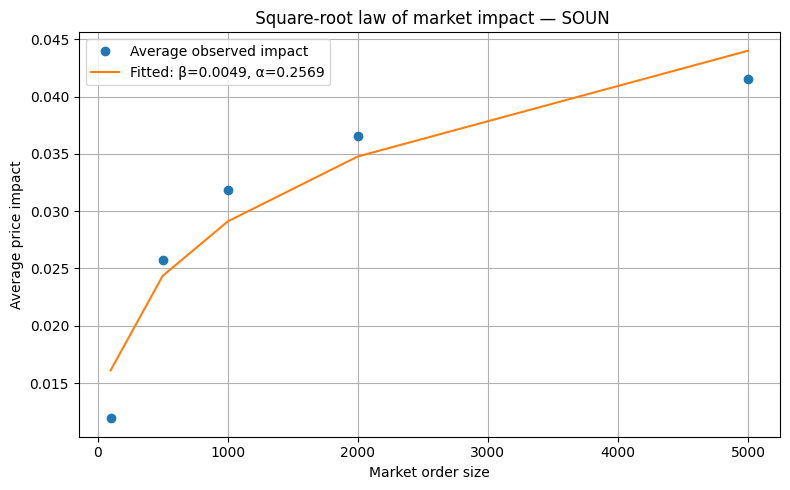

In [ ]:
#Fit the Square-root Law of Market Impact (Power-law fit)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load market impact data
impact_df = pd.read_csv("soun_impact.csv", index_col=0, parse_dates=True)

# Market order sizes
sizes = np.array(impact_df.columns, dtype=int)

# Compute average impact per size (skip NaNs)
avg_impact = impact_df.mean().values

# Remove NaNs for fitting
valid = ~np.isnan(avg_impact)
x = sizes[valid]
y = avg_impact[valid]

# Power-law model: impact = β * size^α
def impact_model(size, beta, alpha):
    return beta * size ** alpha

# Fit model
params, _ = curve_fit(impact_model, x, y)
beta, alpha = params

print(f"✅ Fitted β: {beta:.4f}, α: {alpha:.4f}")

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(x, y, "o", label="Average observed impact")
plt.plot(x, impact_model(x, *params), label=f"Fitted: β={beta:.4f}, α={alpha:.4f}")
plt.xlabel("Market order size")
plt.ylabel("Average price impact")
plt.title(" Square-root law of market impact — SOUN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
